## 0. Download dataset

In [1]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
From (redirected): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM&confirm=t&uuid=82952035-c935-41ac-b6bc-64db67e0e5ff
To: /home/aivn12s1/thangdd/project_scene_text_detection/icdar2003.zip
100%|██████████████████████████████████████| 45.7M/45.7M [00:02<00:00, 19.6MB/s]


## 1. Import libraries

In [2]:
#%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.222 🚀 Python-3.11.5 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12036MiB)
Setup complete ✅ (20 CPUs, 31.1 GB RAM, 408.5/915.3 GB disk)


In [3]:
import os
import shutil
import yaml
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in YOLOv8 format

In [18]:
def extract_data_from_xml(root_dir):
    """
    Trích xuất dữ liệu từ file words.xml trong bộ IC03
    
    Hàm này dùng để trích các thông tin từ file .xml bao gồm: 
    image paths, image sizes, image labels và bboxes 
    
    Parameters:
        root_dir (str): Đường dẫn đến thư mục root của dataset
    
    Returns:
        tuple: Chứa 4 lists lần lượt là: image paths, image sizes, image labels, và bboxes.
    """
    
    # Tạo path đến file words.xml 
    xml_path = os.path.join(root_dir, 'words.xml')
    # Parse file xml
    tree = ET.parse(xml_path)
    # Đọc thẻ root của file
    root = tree.getroot()

    # Khai báo các list rỗng để lưu dữ liệu
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    # Duyệt qua từng thẻ ảnh <image>
    for img in root:
        # Khai báo các list rỗng chứa bboxes và labels của ảnh đang xét
        bbs_of_img = []
        labels_of_img = []

        # Duyệt qua từng thẻ boundingbox 
        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # Bỏ qua trường hợp label không phải kí tự alphabet hoặc number
                if not bb[0].text.isalnum():
                    continue
                    
                # Bỏ qua trường hợp label là chữ 'é' hoặc ñ'
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                # Đưa thông tin tọa độ bbox vào list bbs_of_img
                # Format bbox: (xmin, ymin, bbox_width, bbox_height)
                bbs_of_img.append(
                    [
                        float(bb.attrib['x']), 
                        float(bb.attrib['y']), 
                        float(bb.attrib['width']), 
                        float(bb.attrib['height'])
                    ]
                )
                # Đưa label vào list labels_of_img (đã chuyển chữ viết thường)
                labels_of_img.append(bb[0].text.lower())
                
        # Đưa thông tin path ảnh đang xét vào list img_paths
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        # Đưa thông tin độ phân giải ảnh vào list img_sizes
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        # Đưa list bbox vào list bboxes
        bboxes.append(bbs_of_img)
        # Đưa list labels vào list img_labels
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [19]:
# Thực hiện lời gọi hàm extract_data_from_xml()
dataset_dir = 'datasets/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [ ]:
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

## 3. Convert to YOLOv8 format

In [27]:
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    """
    Thực hiện normalize bounding box
    
    Parameters:
        image_paths (list): Danh sách chứa các path ảnh.
        image_sizes (list): Danh sách chứa độ phân giải ảnh.
        bounding_boxes (list): Danh sách chứa danh sách bounding box.
    
    Returns:
        yolov8_data (list): Danh sách gồm (image_path, image_size, bboxes)
    """
    # Khai báo list rỗng để chứa kết quả
    yolov8_data = []

    # Duyệt qua từng bộ path, resolution và bboxes ảnh.
    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        # Khai báo list rỗng để chứa label (format mới)
        yolov8_labels = []

        # Duyệt qua từng bbox
        for bbox in bboxes:
            x, y, w, h = bbox

            # Thực hiện normalize bbox
            # Format bbox hiện tại: (x_min, y_min, width, height)
            # Format bbox của yolo: (x_center, y_center, width, height)
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Mã class, mặc định = 0 vì chỉ có 1 class 'text'
            class_id = 0

            # Đổi format label
            # Format: "class_id x_center y_center width height"
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data

In [28]:
# Định nghĩa class
class_labels = ['text']

# Thực hiện lời gọi hàm
yolov8_data = convert_to_yolov8_format(
    image_paths, 
    image_sizes, 
    bounding_boxes
)

In [29]:
yolov8_data

[('apanar_06.08.2002/IMG_1261.JPG',
  ['0 0.194375 0.40791666666666665 0.17125 0.1625',
   '0 0.5321875 0.40208333333333335 0.424375 0.1525',
   '0 0.309375 0.5825 0.38875 0.145',
   '0 0.67875 0.5770833333333333 0.27875 0.15583333333333332',
   '0 0.0746875 0.04125 0.059375 0.0725',
   '0 0.2159375 0.03833333333333333 0.123125 0.07333333333333333',
   '0 0.5309375 0.03375 0.071875 0.0675',
   '0 0.19625 0.7645833333333333 0.1425 0.11583333333333333',
   '0 0.3471875 0.7770833333333333 0.103125 0.09083333333333334',
   '0 0.4496875 0.7758333333333334 0.044375 0.08833333333333333',
   '0 0.571875 0.7620833333333333 0.13625 0.1175']),
 ('apanar_06.08.2002/IMG_1263.JPG',
  ['0 0.5346875 0.6008333333333333 0.529375 0.14333333333333334']),
 ('apanar_06.08.2002/IMG_1265.JPG',
  ['0 0.566875 0.21875 0.31375 0.0675',
   '0 0.56 0.22375 0.3375 0.025833333333333333',
   '0 0.5709375 0.28458333333333335 0.255625 0.0575',
   '0 0.5771875 0.33708333333333335 0.165625 0.060833333333333336',
   '0 0.

## 4. Train, val, test split

In [30]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolov8_data, 
    test_size=val_size, 
    random_state=seed,
    shuffle=is_shuffle
)
test_data, val_data = train_test_split(
    test_data, 
    test_size=test_size, 
    random_state=seed,
    shuffle=is_shuffle
)

## 5. Save data

In [37]:
def save_data(data, src_img_dir, save_dir):
    """
    Xây dựng thư mục chứa dữ liệu theo format YOLO
    
    Parameters:
        data (list): Danh sách chứa thông tin label ảnh.
        src_img_dir (str): Path đến thư mục dữ liệu gốc.
        save_dir (str): Path đến thư mục dữ liệu mới.
    """
    # Tạo thư mục dữ liệu mới nếu chưa có
    os.makedirs(save_dir, exist_ok=True)

    # Tạo thư mục 'images' và 'labels'
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    # Duyệt qua từng bộ path, bbox, label ảnh
    for image_path, yolov8_labels in data:
        # Copy ảnh từ thư mục gốc sang thư mục 'images'
        shutil.copy(
            os.path.join(src_img_dir, image_path), 
            os.path.join(save_dir, 'images')
        )

        # Ghi nội dung label vào file image_name.txt ở thư mục 'labels'
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")

In [38]:
# Thực hiện lời gọi hàm cho 3 set train, val, test
save_yolo_data_dir = 'datasets/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(
    save_yolo_data_dir,
    'train'
)
save_val_dir = os.path.join(
    save_yolo_data_dir,
    'val'
)
save_test_dir = os.path.join(
    save_yolo_data_dir,
    'test'
)

save_data(
    train_data, 
    dataset_dir, 
    save_train_dir
)
save_data(
    test_data, 
    dataset_dir, 
    save_val_dir
)
save_data(
    val_data, 
    dataset_dir, 
    save_test_dir
)

## 6. Create yaml file

In [39]:
data_yaml = {
    'path': 'yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## 7. Training

In [8]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s.yaml').load('yolov8s.pt') 

# Train the model
epochs = 200
imgsz = 1024
results = model.train(
    data=yolo_yaml_path, 
    epochs=epochs, 
    imgsz=imgsz,
    project='models',
    name='yolov8/detect/train'
)


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

train: Scanning /home/aivn12s1/thangdd/project_scene_text_detection/datasets/yolo_data/train/labels.cache... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [
val: Scanning /home/aivn12s1/thangdd/project_scene_text_detection/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?


Plotting labels to models/yolov8/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to models/yolov8/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      10.7G      2.038       5.46      1.827         61       1024: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         43        200      0.312      0.455      0.307       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200        10G      1.102      1.815      1.182         69       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         43        200      0.718      0.714      0.775      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      10.2G      1.049      1.449      1.116         42       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         43        200      0.727      0.667      0.692      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200        10G      1.142      1.336      1.165        109       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         43        200        0.7       0.72      0.703      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      10.3G      1.141      1.237      1.196         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         43        200      0.497       0.61      0.522      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      10.1G      1.193      1.148      1.174         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         43        200      0.491      0.695       0.56      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      10.3G      1.188      1.078      1.215         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         43        200      0.289       0.47      0.254       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      10.1G      1.362      1.351       1.29         30       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         43        200      0.456      0.519      0.418      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      10.2G      1.284      1.222      1.253         51       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         43        200      0.584      0.635      0.605      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      10.2G      1.228      1.223      1.245         84       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         43        200      0.352      0.585      0.417      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      10.2G      1.163      1.121      1.158         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         43        200       0.54       0.66      0.595      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      10.1G      1.231      1.171      1.231         73       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         43        200      0.714       0.65      0.688      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200        10G       1.15      1.087      1.208         39       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         43        200      0.724      0.645      0.717       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      10.3G      1.113      1.098      1.188         60       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         43        200      0.759      0.693      0.755      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      9.97G       1.13      1.035      1.169         43       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         43        200      0.688       0.71      0.698       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      10.1G      1.145      1.081      1.192         56       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         43        200      0.664       0.72      0.706      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      9.83G      1.157      1.009      1.177         83       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         43        200      0.797       0.75      0.795      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      10.1G      1.069     0.9139      1.139         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         43        200      0.676      0.745      0.726      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      10.2G      1.065     0.9153      1.136         86       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         43        200      0.667      0.782      0.714      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      9.98G      1.109     0.9531      1.135         58       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         43        200      0.782      0.805      0.822      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      9.99G      1.046     0.8734      1.123         62       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         43        200      0.823      0.838      0.871      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.84G      1.071     0.9147       1.14         65       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         43        200      0.792       0.85      0.866      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      10.1G      1.041     0.8788      1.106         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         43        200      0.697      0.865      0.824      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      10.1G      1.046     0.8848      1.122         74       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200       0.82       0.84      0.865      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200        10G       1.01     0.8666      1.122         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         43        200      0.749       0.85       0.79      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      10.1G      1.013     0.8465      1.123         27       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.814      0.852      0.841      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      10.4G     0.9925     0.8562      1.119         34       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.769      0.783      0.777      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200        10G      1.013     0.8631      1.118         40       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         43        200       0.81       0.83      0.818      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      9.81G      0.975     0.8163      1.094         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.728      0.805      0.775      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      10.3G      1.013     0.8064      1.082         54       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.796       0.86      0.839      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      10.2G     0.9685     0.7779      1.087         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.785      0.785      0.833      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      10.4G      1.038     0.7939      1.126         81       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200       0.78       0.84      0.836      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      10.4G     0.9601     0.7974      1.071         46       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         43        200       0.76       0.88      0.859      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      10.2G      0.967     0.7689      1.074         72       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.829      0.865      0.862       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200        10G      0.949     0.7335      1.064         50       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.823      0.895      0.909       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      9.98G     0.9496     0.7952      1.085         64       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.875       0.83      0.888      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      10.4G     0.9438     0.7929      1.063         81       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         43        200      0.835       0.86      0.867      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      10.1G     0.9581     0.7137      1.068         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.849      0.855      0.862      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      10.1G     0.9228     0.7305      1.074         90       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.875       0.86      0.896      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      10.1G     0.9219     0.7315      1.063         46       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.839      0.859      0.879      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200        10G     0.9036     0.7204      1.064         68       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.826      0.815      0.839      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      9.85G     0.9022     0.7042      1.051         61       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.859      0.855      0.888      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      10.1G     0.8519     0.6671       1.03         48       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.824       0.88      0.869      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      10.3G     0.9102     0.6897      1.038         32       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.827      0.895      0.855      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200        10G     0.8758     0.7133      1.039         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200       0.82       0.89       0.87      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      10.2G     0.8723     0.7161      1.042         48       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.828      0.875      0.885      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      10.3G     0.8416     0.6579       1.03         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.807       0.92      0.885      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      10.1G     0.9288     0.7022      1.042         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.839      0.855      0.894      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.98G     0.8537     0.6592      1.016         96       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200       0.87      0.834      0.878      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      10.3G     0.8478     0.6677      1.026         63       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.802      0.914      0.875      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      9.98G     0.8723     0.6863      1.024         62       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.868      0.888      0.908      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      10.1G     0.8705     0.6908      1.014         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.818      0.879       0.87      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      9.82G     0.9138     0.7017      1.025         36       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         43        200      0.836       0.87      0.859      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      10.2G     0.8671     0.6574      1.011         61       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.888      0.872       0.88      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      10.1G      0.835     0.6377      1.002         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.869      0.845       0.89      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      10.2G     0.8264     0.6257      1.014         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.865       0.89        0.9      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      10.1G     0.8076     0.6095      1.006         76       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.887       0.86      0.907      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200        10G     0.8212     0.5927          1         57       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.802      0.932      0.912      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      10.2G     0.8103      0.614     0.9915         70       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.822       0.87      0.894      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      10.1G     0.8017      0.612      1.006         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.844      0.841      0.884      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.98G      0.789     0.5887     0.9979         60       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.887      0.885      0.909      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      10.2G     0.8084     0.6415      1.016         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.895      0.835      0.897      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      10.4G     0.8165     0.6088      1.016         70       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200       0.84       0.87      0.881      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      10.2G     0.8054     0.6119     0.9946         51       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.878       0.83      0.881      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200        10G     0.8301      0.625      1.014         63       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.859      0.852      0.895      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      10.2G     0.8126     0.6188      1.005         59       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.812      0.865      0.864      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      10.1G     0.8164     0.5988     0.9856         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.885      0.865      0.911      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      9.97G     0.7694     0.5858     0.9736         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.862      0.878      0.921      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200        10G     0.8035     0.6251      1.004         44       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.858      0.907      0.916      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      10.3G     0.8078     0.5968      1.004         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.847      0.888      0.919      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      10.3G      0.823     0.5893     0.9955         99       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.878      0.835      0.888      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      10.2G     0.8193     0.6034     0.9973        122       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200       0.89      0.853       0.91      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      10.1G     0.8006     0.5908     0.9878         68       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.796      0.877      0.881      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      10.4G     0.8092     0.5838      1.019         46       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.826      0.865      0.889      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200        10G     0.7739     0.5568      0.966         68       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.882      0.859      0.917      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      10.1G     0.7825     0.5723     0.9967         42       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.894      0.905      0.944      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      9.96G     0.7975     0.5703     0.9804         37       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.889      0.865       0.91      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      10.1G     0.7741     0.5605     0.9831         38       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.887      0.864      0.904      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      9.59G     0.7444     0.5098     0.9602         56       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.865      0.885      0.912      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.86G     0.7842     0.5564     0.9709         51       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.871       0.88      0.901      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.82G     0.7647     0.5495      0.967         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.859      0.887        0.9      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      9.88G     0.7882     0.5631     0.9924         56       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.877      0.889      0.908      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200        10G     0.7721     0.5282      0.987         90       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.881      0.885      0.912      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      10.1G      0.764     0.5327     0.9747         73       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.894      0.888      0.908      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      9.83G      0.771     0.5345     0.9872         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.876       0.92       0.93      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      9.98G     0.7189     0.5085     0.9514         54       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.896        0.9      0.934      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      10.2G     0.7284     0.5083     0.9463        102       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.929      0.895      0.929      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      10.2G     0.7177     0.4907     0.9504         72       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.895       0.89      0.918      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      9.89G     0.7475     0.5162     0.9614         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.874        0.9      0.925      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      10.2G     0.6991     0.4987     0.9448         72       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.882      0.899      0.919      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      10.1G     0.7358     0.5391     0.9641         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.899      0.925      0.927      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200        10G     0.7164      0.522      0.976         39       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.857      0.925      0.928      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200        10G     0.7425     0.4998     0.9618         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.926       0.88      0.926      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      10.2G     0.7087     0.5076     0.9611         37       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.897       0.89      0.931      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      10.2G     0.6805     0.4887      0.958         44       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.932      0.829      0.912       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200        10G     0.7039     0.4993     0.9643         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.871      0.912      0.928      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      10.3G     0.7125     0.4941     0.9457         79       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.919      0.854      0.931      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      9.97G     0.7084      0.507     0.9585         74       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.844      0.945      0.917      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      10.2G     0.7159     0.5072     0.9606         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.821      0.916      0.918      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200        10G     0.7116     0.4986       0.95         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.891        0.9       0.93      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200        10G      0.734     0.5084     0.9808         30       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.878        0.9      0.926      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      10.3G      0.716     0.4876     0.9655         56       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.913       0.89       0.93      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      10.2G     0.7098     0.5014     0.9525         50       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.902      0.876      0.917      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      10.1G     0.7147     0.4858     0.9514         71       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.884       0.91      0.926      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      9.84G     0.7188     0.4832     0.9425         84       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.897       0.92      0.927      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      10.4G     0.6848     0.4811     0.9554         36       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.848      0.922      0.922      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      9.99G     0.6566     0.4635     0.9465         59       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.862      0.909      0.909        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200        10G     0.6847     0.4972     0.9479         43       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.878       0.92      0.926      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      10.2G     0.6905     0.4742      0.956         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.868      0.935      0.942      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      10.3G     0.6664     0.4566     0.9486         62       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.879      0.908      0.931      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200        10G     0.7074     0.4937     0.9597         97       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.896        0.9      0.927      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.97G     0.6984     0.4846     0.9559         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.886        0.9      0.923      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200        10G     0.6403      0.478     0.9298         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.901      0.869      0.916      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      9.86G     0.6588     0.4649     0.9263         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.912       0.88      0.923      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      10.2G     0.6572     0.4559      0.933         85       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.884      0.912      0.927      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200        10G     0.6644     0.4656     0.9399         65       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.915       0.84      0.921      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      10.2G       0.68     0.4667     0.9364         76       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.908      0.845      0.912      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.99G     0.6721     0.4681     0.9495         62       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.875       0.87      0.915      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      10.1G     0.6594     0.4641     0.9364         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.884       0.87      0.917      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      10.2G     0.6604     0.4596     0.9259         62       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.895       0.92      0.927      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200        10G     0.6366     0.4405     0.9374         36       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.891       0.91      0.922      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      10.1G     0.6566     0.4488     0.9361         59       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.887      0.905      0.914      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      9.95G     0.6516     0.4376     0.9312         38       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200        0.9      0.901      0.916        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200        10G     0.6815     0.4552     0.9473         53       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.896       0.91       0.93      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200        10G     0.6128     0.4181     0.9213         66       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.898        0.9      0.931      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      10.3G      0.615     0.4164     0.9153         56       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.912      0.882      0.926      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      10.2G      0.622     0.4406     0.9324         30       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.926       0.86      0.918      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      10.1G     0.6326     0.4331      0.938         44       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.921       0.88       0.93      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      9.84G     0.6664     0.4528      0.931        123       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.913      0.905      0.935      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      10.3G     0.6315     0.4333     0.9233         46       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.933      0.907      0.931      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      10.2G     0.6414     0.4343     0.9206         54       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.915      0.917      0.927      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.97G     0.6251     0.4333     0.9326         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.897      0.905      0.929      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      9.94G     0.5953     0.4066     0.9136         80       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.918      0.894      0.935      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      10.2G     0.6122     0.4058     0.9187         62       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.908       0.91      0.934      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      10.4G     0.5798     0.3987     0.9212         43       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.912      0.886      0.926      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      10.2G      0.593     0.4051     0.9105         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.911        0.9      0.928      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      9.98G     0.5916     0.4067     0.9246         27       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.863      0.913      0.921      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      10.2G     0.5775     0.4035     0.9029         76       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.877      0.905      0.933      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      10.1G     0.5962     0.4026     0.9152        102       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.881      0.925      0.938      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      10.3G     0.5905     0.4191     0.9135        111       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.883      0.915      0.919      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      10.4G     0.5746     0.4011     0.9131         88       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.885      0.884      0.908       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      10.2G      0.594     0.4143     0.9139         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.894       0.89      0.915      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      10.1G     0.5757     0.3979     0.9128         58       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.934       0.89      0.936      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      10.1G     0.5922     0.4124     0.9303         50       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200       0.91      0.895      0.931      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      10.2G     0.6002     0.4039     0.9229         75       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.878        0.9      0.919      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      10.2G     0.5726     0.4024     0.9108         51       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.927      0.885      0.918       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      10.1G     0.6099     0.4194     0.9132         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.915        0.9      0.931      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200        10G       0.59     0.4062     0.9197         33       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.908      0.905      0.931      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      9.84G     0.5782     0.4003     0.9112         44       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200       0.89      0.885      0.923      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      10.3G     0.5568     0.3895     0.9053         67       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.909      0.897      0.923       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      10.4G     0.5541      0.383     0.9187         49       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.916       0.89      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200        10G      0.579     0.4091     0.9091         46       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.899        0.9      0.925      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      10.3G     0.5628     0.3805     0.9099         74       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.881      0.915      0.931       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      10.2G     0.5477     0.3714      0.902         69       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.897      0.917      0.939      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      10.4G     0.5655     0.3992     0.8925         69       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.909       0.92      0.937      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      10.1G     0.5665     0.3822     0.9066         65       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.892      0.913      0.933      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      10.3G     0.5568      0.401     0.9136         21       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.904      0.897      0.932      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      10.3G     0.5739     0.3915     0.9148         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200       0.91      0.875      0.931      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      10.1G     0.5659     0.3943     0.9151         73       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.892      0.895      0.935      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.99G     0.5719     0.3858     0.9052         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.916        0.9      0.943      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      10.1G     0.5626      0.382     0.8986         57       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.902       0.91      0.946      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      10.1G      0.554     0.3691     0.8998         45       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.888        0.9       0.94       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      10.2G     0.5889     0.3924     0.9074         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200        0.9       0.87      0.931      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200        10G     0.5537     0.3749     0.8906         63       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.912      0.879      0.928      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      10.2G     0.5337     0.3707     0.8891         63       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.919      0.908      0.929      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      10.3G     0.5362     0.3628     0.9043         45       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.932        0.9      0.931      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      10.1G     0.5232     0.3626     0.8841         78       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.951      0.895      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      10.1G     0.5174     0.3492     0.8839         86       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.932      0.888      0.931       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      10.1G     0.5085     0.3627     0.8955         51       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.936      0.884      0.932      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      10.2G     0.5075     0.3524     0.8828         70       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.927      0.885      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      10.2G     0.5273     0.3618     0.9017         65       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.941      0.885       0.93      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      10.4G     0.5052     0.3335     0.8917         40       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.922       0.88      0.927      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      9.94G     0.4984     0.3512     0.8829         73       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.887      0.915      0.928      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      10.3G     0.5101     0.3493     0.8829         56       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.913      0.895      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      10.4G     0.5346     0.3613     0.8934         87       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.922      0.892      0.938      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      10.4G     0.5363     0.3677     0.9039         47       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.926      0.879      0.938      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      10.3G     0.5256     0.3621     0.8931         89       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.897      0.919      0.939      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      10.2G     0.5179     0.3521     0.8848         43       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.933      0.895      0.941      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      10.2G     0.4996     0.3403     0.8676         46       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.911       0.92      0.943      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      10.2G     0.5052     0.3602     0.8915         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.934        0.9      0.942      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      10.2G      0.504     0.3426     0.8987         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.928      0.898      0.937      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.99G     0.5268     0.3573     0.9009         32       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.928       0.91      0.933      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      9.99G      0.518     0.3512     0.8996         60       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.923      0.903      0.932      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200        10G     0.4973     0.3408     0.8755         63       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.903      0.929       0.93      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200        10G     0.4943      0.343      0.888         33       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.912      0.925      0.928      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      9.81G      0.513     0.3581     0.8966         42       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.906       0.93      0.929      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      10.1G     0.5048     0.3472     0.8896         48       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.898      0.935      0.927      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      10.2G     0.4713     0.3255     0.8742         55       1024: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.904       0.92      0.927      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200        10G     0.4767     0.3317     0.8894         36       1024: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.914        0.9      0.929      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      9.81G     0.4745     0.3295     0.8592         44       1024: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.939      0.885      0.928      0.738


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      10.2G     0.4645     0.3405     0.8518         52       1024: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         43        200      0.937      0.892      0.922      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      9.93G     0.4992     0.3399     0.8599         20       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.935      0.895      0.921      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200        10G     0.4577     0.3297     0.8538         16       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.935      0.895      0.918      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      10.2G     0.4712     0.3348     0.8476         19       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.923        0.9       0.92      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      10.1G     0.4707     0.3364     0.8535         70       1024: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.924        0.9       0.92      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      10.1G     0.4505      0.319       0.85         19       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         43        200      0.918      0.899      0.921      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      10.2G     0.4456     0.3072     0.8446         35       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.912        0.9      0.921      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      10.2G     0.4405     0.3164     0.8565         21       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         43        200      0.916        0.9      0.922      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      9.93G     0.4485      0.322      0.841         41       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.908       0.91      0.923      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      10.1G     0.4256     0.3037     0.8328         56       1024: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         43        200      0.924      0.895      0.924      0.736



200 epochs completed in 0.338 hours.
Optimizer stripped from models/yolov8/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from models/yolov8/detect/train/weights/best.pt, 22.6MB

Validating models/yolov8/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.11.5 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 3060, 12036MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


                   all         43        200      0.933      0.895      0.941      0.751
Speed: 0.2ms preprocess, 7.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to models/yolov8/detect/train


## 8. Evaluation

In [9]:
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project='models',
    name='yolov8/detect/val'
)  

Ultralytics YOLOv8.0.222 🚀 Python-3.11.5 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 3060, 12036MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /home/aivn12s1/thangdd/project_scene_text_detection/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


                   all         43        200      0.933      0.895      0.941      0.748
Speed: 0.3ms preprocess, 12.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to models/yolov8/detect/val


## 9. Inference

In [40]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    
    for prediction in predictions:
        conf_score = prediction['confidence']
        
        if conf_score < conf_thres:
            continue
            
        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])
        
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

In [47]:
!ls datasets/SceneTrialTrain/apanar_06.08.2002

IMG_1247.JPG  IMG_1269.JPG  IMG_1289.JPG  IMG_1300.JPG	IMG_1308.JPG
IMG_1252.JPG  IMG_1281.JPG  IMG_1290.JPG  IMG_1301.JPG	IMG_1311.JPG
IMG_1253.JPG  IMG_1282.JPG  IMG_1291.JPG  IMG_1302.JPG	IMG_1312.JPG
IMG_1255.JPG  IMG_1283.JPG  IMG_1292.JPG  IMG_1303.JPG	Img_1313.jpg
IMG_1259.JPG  IMG_1284.JPG  IMG_1293.JPG  IMG_1304.JPG	IMG_1315.JPG
IMG_1261.JPG  IMG_1285.JPG  IMG_1294.JPG  Img_1305.jpg	IMG_1316.JPG
IMG_1263.JPG  IMG_1286.JPG  IMG_1298.JPG  IMG_1306.JPG	IMG_1317.JPG
IMG_1265.JPG  IMG_1288.JPG  IMG_1299.JPG  IMG_1307.JPG


{'name': 'text', 'class': 0, 'confidence': 0.9537504315376282, 'box': {'x1': 171.4465789794922, 'y1': 392.06658935546875, 'x2': 447.82232666015625, 'y2': 584.3841552734375}}


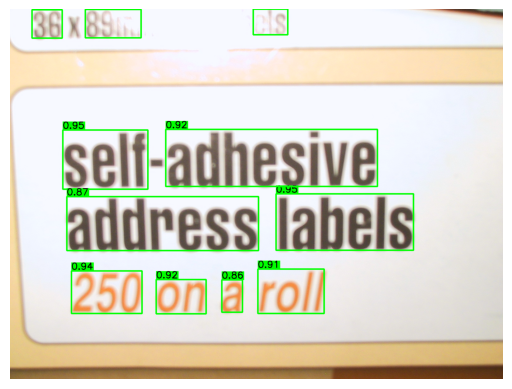

In [49]:
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train/weights/best.pt'
img_path = 'datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG'
conf_thres=0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].tojson())
print(predictions[0])
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()